# **Activity 3: Docking Results Statistical Interpretation**

Before you proceed this workflow, I encourage you to follow the tutorials on ```00_tutorials/``` folder prior programming to have everything downloaded.

To proceed this workflow, you will also have been executed the previous workflow: ```01_docking_human_proteins.ipynb```.

Make sure you already have installed ```pandas```, ```numpy```, ```matplotlib```, ```seaborn```, ```scipy``` libraries. Otherwise, copy the following lines and paste it on the terminal:

1. ```conda activate vina```
2. ```conda install numpy matplotlib seaborn scipy```

## **1. Import libraries**

In [1]:
# Library for DataFrame Manipulation
import pandas as pd
# Libraries for numeric manipulation and statistical analysis
import numpy as np
from scipy import stats
# Libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## **2. Load Docking Results from CSV file**

In [2]:
# Load the CSV files
summary_data_phb = "output/docking_results_summary.csv"
summary_pd_phb = pd.read_csv(summary_data_phb)

validation_data_pga = "output/docking_results_pga_summary.csv"
summary_pd_pga = pd.read_csv(validation_data_pga)

# Add a column to identify the polymer type
summary_pd_phb['polymer_type'] = 'PHB'
summary_pd_pga['polymer_type'] = 'PGA'

# Combine both datasets for comparative analysis
summary_pd_combined = pd.concat([summary_pd_phb, summary_pd_pga], ignore_index=True)

print(f"PHB dataset: {len(summary_pd_phb)} docking poses")
print(f"PGA dataset: {len(summary_pd_pga)} docking poses")
print(f"Combined dataset: {len(summary_pd_combined)} docking poses")


PHB dataset: 704 docking poses
PGA dataset: 712 docking poses
Combined dataset: 1416 docking poses


## **3.  AFFINITY DISTRIBUTION ANALYSIS**

Statistical descriptive analysis of binding affinities for both PHB and PGA polymers.
Comparison of mean, standard deviation, skewness, and kurtosis metrics.

In [3]:
print("PHB AFFINITY STATISTICS")
print("="*70)
affinity_stats_phb = summary_pd_phb['affinity_kcal_mol'].describe()
print(affinity_stats_phb)
print(f"\nSkewness: {summary_pd_phb['affinity_kcal_mol'].skew():.3f}")
print(f"Kurtosis: {summary_pd_phb['affinity_kcal_mol'].kurtosis():.3f}")

print("\nPGA AFFINITY STATISTICS")
print("="*70)
affinity_stats_pga = summary_pd_pga['affinity_kcal_mol'].describe()
print(affinity_stats_pga)
print(f"\nSkewness: {summary_pd_pga['affinity_kcal_mol'].skew():.3f}")
print(f"Kurtosis: {summary_pd_pga['affinity_kcal_mol'].kurtosis():.3f}")

# Statistical comparison between PHB and PGA
t_stat, p_value = stats.ttest_ind(summary_pd_phb['affinity_kcal_mol'], 
                                   summary_pd_pga['affinity_kcal_mol'])

print("\nPHB vs PGA COMPARISON")
print("="*70)
print(f"Mean difference: {summary_pd_phb['affinity_kcal_mol'].mean() - summary_pd_pga['affinity_kcal_mol'].mean():.3f} kcal/mol")
print(f"T-test: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("\t- RESULT: Significant difference between PHB and PGA")
else:
    print("\t- RESULT: No significant difference between PHB and PGA")

PHB AFFINITY STATISTICS
count    704.000000
mean      -4.659869
std        1.024192
min       -7.803000
25%       -5.221750
50%       -4.582500
75%       -4.034500
max       -2.031000
Name: affinity_kcal_mol, dtype: float64

Skewness: -0.231
Kurtosis: 0.234

PGA AFFINITY STATISTICS
count    712.000000
mean      -4.263364
std        0.847165
min       -6.134000
25%       -4.858000
50%       -4.335500
75%       -3.711750
max       -1.832000
Name: affinity_kcal_mol, dtype: float64

Skewness: 0.308
Kurtosis: -0.174

PHB vs PGA COMPARISON
Mean difference: -0.397 kcal/mol
T-test: t=-7.942, p=0.0000
	- RESULT: Significant difference between PHB and PGA


## **4. BINDING AFFINITY THRESHOLDS**

Classification of all affinities into four categories based on established binding strength cutoffs (Strong < -8.0; Moderate -6.0 to -8.0; Weak -4.0 to -6.0; Very Weak > -4.0 kcal/mol).

In [4]:
# Classify affinities by potentiality
def classify_affinity(affinity):
    if affinity < -8.0:
        return "Strong"
    elif affinity < -6.0:
        return "Moderate"
    elif affinity < -4.0:
        return "Weak"
    else:
        return "Very Weak"

summary_pd_phb['affinity_class'] = summary_pd_phb['affinity_kcal_mol'].apply(classify_affinity)
summary_pd_pga['affinity_class'] = summary_pd_pga['affinity_kcal_mol'].apply(classify_affinity)
summary_pd_combined['affinity_class'] = summary_pd_combined['affinity_kcal_mol'].apply(classify_affinity)

print("PHB Affinity Classification:")
print(summary_pd_phb['affinity_class'].value_counts().sort_index())

print("\nPGA Affinity Classification:")
print(summary_pd_pga['affinity_class'].value_counts().sort_index())

PHB Affinity Classification:
affinity_class
Moderate      85
Very Weak    167
Weak         452
Name: count, dtype: int64

PGA Affinity Classification:
affinity_class
Moderate       1
Very Weak    259
Weak         452
Name: count, dtype: int64


## **5. AFFINITY BY PROTEIN**

Grouped analysis of binding affinities by protein type using mean, standard deviation, minimum, and maximum values.

In [5]:
# Get general statistical information from binding affinities of proteins
print("PHB - AFFINITY BY PROTEIN")
print("="*70)
protein_stats_phb = summary_pd_phb.groupby('protein_file')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(protein_stats_phb)

print("\nPGA - AFFINITY BY PROTEIN")
print("="*70)
protein_stats_pga = summary_pd_pga.groupby('protein_file')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(protein_stats_pga)

PHB - AFFINITY BY PROTEIN
                                                    count   mean    std  \
protein_file                                                              
1CSG_Granulocyte-macrophage_colony-stimulating_...     88 -4.969  0.550   
1RG8_Heparin-binding_growth_factor_1.pdbqt             96 -6.211  0.982   
1TGJ_TRANSFORMING_GROWTH_FACTOR-BETA_3.pdbqt           96 -4.829  0.529   
1VPF_VASCULAR_ENDOTHELIAL_GROWTH_FACTOR.pdbqt          88 -4.268  0.553   
2Z80_Toll-like_receptor_2,_Variable_lymphocyte_...     96 -4.958  0.501   
4BSO_R-SPONDIN-1.pdbqt                                 96 -4.199  0.599   
6EC0_Keratin_1.pdbqt                                   96 -3.994  0.652   
7CWK_Collagen_type_I.pdbqt                             48 -3.027  0.523   

                                                      min    max  
protein_file                                                      
1CSG_Granulocyte-macrophage_colony-stimulating_... -6.089 -3.583  
1RG8_Heparin-binding_g

## **6. AFFINITY BY PHB CHAIN LENGTH**

Grouped analysis by chain length (1-12 units) with ANOVA (F=35.434, p<0.0001) to test for significant differences. Optimal chain length identified by minimum mean affinity.

In [6]:
# Extract chain length from ligand filename for both polymers
summary_pd_phb['chain_units'] = summary_pd_phb['ligand_file'].str.extract(r'phb_(\d+)_unit', expand=False).astype(int)
summary_pd_pga['chain_units'] = summary_pd_pga['ligand_file'].str.extract(r'pga_(\d+)_unit', expand=False).astype(int)

print("PHB - AFFINITY BY CHAIN LENGTH")
print("="*70)
ligand_stats_phb = summary_pd_phb.groupby('chain_units')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(ligand_stats_phb)

# ANOVA for PHB
chain_groups_phb = [summary_pd_phb[summary_pd_phb['chain_units'] == i]['affinity_kcal_mol'].values
                    for i in sorted(summary_pd_phb['chain_units'].unique())]
f_stat_phb, p_val_phb = stats.f_oneway(*chain_groups_phb)
print(f"\nANOVA (all chain lengths): F={f_stat_phb:.3f}, p={p_val_phb:.4f}")

optimal_chain_phb = ligand_stats_phb['mean'].idxmin()
optimal_affinity_phb = ligand_stats_phb.loc[optimal_chain_phb, 'mean']
print(f"\nOptimal PHB chain length: {optimal_chain_phb} units")
print(f"\tMean affinity: {optimal_affinity_phb:.3f} kcal/mol")

print("\nPGA - AFFINITY BY CHAIN LENGTH")
print("="*70)
ligand_stats_pga = summary_pd_pga.groupby('chain_units')['affinity_kcal_mol'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(3)
print(ligand_stats_pga)

# ANOVA for PGA
chain_groups_pga = [summary_pd_pga[summary_pd_pga['chain_units'] == i]['affinity_kcal_mol'].values
                    for i in sorted(summary_pd_pga['chain_units'].unique())]
f_stat_pga, p_val_pga = stats.f_oneway(*chain_groups_pga)
print(f"\nANOVA (all chain lengths): F={f_stat_pga:.3f}, p={p_val_pga:.4f}")

optimal_chain_pga = ligand_stats_pga['mean'].idxmin()
optimal_affinity_pga = ligand_stats_pga.loc[optimal_chain_pga, 'mean']
print(f"\nOptimal PGA chain length: {optimal_chain_pga} units")
print(f"\tMean affinity: {optimal_affinity_pga:.3f} kcal/mol")

PHB - AFFINITY BY CHAIN LENGTH
             count   mean    std    min    max
chain_units                                   
1               64 -3.179  0.634 -4.323 -2.031
2               64 -3.931  0.666 -5.175 -2.466
3               64 -4.448  0.934 -6.280 -2.764
4               64 -4.701  0.877 -6.982 -3.377
5               64 -4.678  0.958 -6.911 -3.225
6               56 -4.936  0.818 -6.618 -3.822
7               56 -5.135  0.737 -6.821 -4.202
8               64 -4.733  0.880 -6.894 -3.489
9               56 -5.650  0.865 -7.803 -4.588
10              56 -5.036  0.800 -6.676 -3.973
11              40 -4.998  0.774 -6.427 -4.005
12              56 -4.916  0.875 -7.001 -3.746

ANOVA (all chain lengths): F=35.434, p=0.0000

Optimal PHB chain length: 9 units
	Mean affinity: -5.650 kcal/mol

PGA - AFFINITY BY CHAIN LENGTH
             count   mean    std    min    max
chain_units                                   
1               64 -2.850  0.527 -3.825 -1.832
2               64 -3.53

In [7]:
print("OPTIMAL CHAIN LENGTH COMPARISON")
print("="*70)

phb_optimal = summary_pd_phb[summary_pd_phb['chain_units'] == optimal_chain_phb]['affinity_kcal_mol']
pga_optimal = summary_pd_pga[summary_pd_pga['chain_units'] == optimal_chain_pga]['affinity_kcal_mol']

t_stat, p_val = stats.ttest_ind(phb_optimal, pga_optimal)
print(f"\nPHB optimal ({optimal_chain_phb} units): {phb_optimal.mean():.3f} ± {phb_optimal.std():.3f} kcal/mol")
print(f"PGA optimal ({optimal_chain_pga} units): {pga_optimal.mean():.3f} ± {pga_optimal.std():.3f} kcal/mol")
print(f"\nT-test: t={t_stat:.3f}, p={p_val:.4f}")

OPTIMAL CHAIN LENGTH COMPARISON

PHB optimal (9 units): -5.650 ± 0.865 kcal/mol
PGA optimal (9 units): -4.752 ± 0.719 kcal/mol

T-test: t=-5.978, p=0.0000


Cohen's d is a standardized effect size measure that quantifies the magnitude of difference between two group means, expressed in units of standard deviation. Cohen's d is a standardized effect size measure that quantifies the magnitude of difference between two group means, expressed in units of standard deviation.

In [8]:
# Calculate Cohen's d for effect size
mean_diff = phb_optimal.mean() - pga_optimal.mean()
pooled_std = np.sqrt(((len(phb_optimal)-1)*phb_optimal.std()**2 + 
                      (len(pga_optimal)-1)*pga_optimal.std()**2) / 
                     (len(phb_optimal) + len(pga_optimal) - 2))
cohens_d = mean_diff / pooled_std

print(f"\nMean difference: {mean_diff:.3f} kcal/mol")
print(f"Cohen's d: {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    print("\t- Negligible effect")
elif abs(cohens_d) < 0.5:
    print("\t- Small effect")
elif abs(cohens_d) < 0.8:
    print("\t- Medium effect")
else:
    print("\t- LARGE EFFECT")


Mean difference: -0.899 kcal/mol
Cohen's d: -1.130
	- LARGE EFFECT


## **7. RMSD ANALYSIS (POSE QUALITY)**

Calculation of RMSD lower bound (RMSD_LB), upper bound (RMSD_UB), and spread (RMSD_UB - RMSD_LB) across all 704 poses. Mean spread compared to 5 Å threshold for well-defined binding.

- Mean RMSD_LB = 8.25 Å (std = 12.34).
- Mean RMSD_UB = 12.17 Å (std = 12.88).
- Mean RMSD spread = 3.93 Å (well below 5 Å threshold).

In [9]:
# Calculate RMSD spread for both datasets
summary_pd_phb['rmsd_spread'] = summary_pd_phb['rmsd_ub'] - summary_pd_phb['rmsd_lb']
summary_pd_pga['rmsd_spread'] = summary_pd_pga['rmsd_ub'] - summary_pd_pga['rmsd_lb']

print("\nPHB - RMSD STATISTICS")
print("="*70)
print("\nRMSD Lower Bound (RMSD_LB):")
print(summary_pd_phb['rmsd_lb'].describe().round(3))
print("\nRMSD Upper Bound (RMSD_UB):")
print(summary_pd_phb['rmsd_ub'].describe().round(3))
print("\nRMSD Spread (UB - LB):")
print(summary_pd_phb['rmsd_spread'].describe().round(3))

print("\nPGA - RMSD STATISTICS")
print("="*70)
print("\nRMSD Lower Bound (RMSD_LB):")
print(summary_pd_pga['rmsd_lb'].describe().round(3))
print("\nRMSD Upper Bound (RMSD_UB):")
print(summary_pd_pga['rmsd_ub'].describe().round(3))
print("\nRMSD Spread (UB - LB):")
print(summary_pd_pga['rmsd_spread'].describe().round(3))

# Compare RMSD spreads
t_stat, p_val = stats.ttest_ind(summary_pd_phb['rmsd_spread'], 
                                 summary_pd_pga['rmsd_spread'])

print("\nPHB vs PGA RMSD SPREAD COMPARISON")
print("="*70)
print(f"PHB mean RMSD spread: {summary_pd_phb['rmsd_spread'].mean():.3f} Å")
print(f"PGA mean RMSD spread: {summary_pd_pga['rmsd_spread'].mean():.3f} Å")
print(f"T-test: t={t_stat:.3f}, p={p_val:.4f}")



PHB - RMSD STATISTICS

RMSD Lower Bound (RMSD_LB):
count    704.000
mean       8.247
std       12.338
min        0.000
25%        1.879
50%        3.036
75%        8.660
max      104.192
Name: rmsd_lb, dtype: float64

RMSD Upper Bound (RMSD_UB):
count    704.000
mean      12.172
std       12.883
min        0.000
25%        4.387
50%        8.720
75%       15.203
max      109.151
Name: rmsd_ub, dtype: float64

RMSD Spread (UB - LB):
count    704.000
mean       3.926
std        3.175
min        0.000
25%        1.354
50%        3.437
75%        5.813
max       15.558
Name: rmsd_spread, dtype: float64

PGA - RMSD STATISTICS

RMSD Lower Bound (RMSD_LB):
count    712.000
mean       9.259
std       14.451
min        0.000
25%        1.646
50%        2.375
75%       11.880
max      117.963
Name: rmsd_lb, dtype: float64

RMSD Upper Bound (RMSD_UB):
count    712.000
mean      12.326
std       14.809
min        0.000
25%        3.445
50%        6.994
75%       15.630
max      124.714
Name: rmsd

## **8. POSE RANKING (First Pose vs Others)**

Two-population comparison (Pose 1 vs Poses 2-12) using independent samples t-test. Null hypothesis: no significant difference in affinity between first and other poses.

- First pose affinity = -4.864 ± 1.049 kcal/mol.
- Other poses = -4.631 ± 1.018 kcal/mol.
- Difference = 0.233 kcal/mol.
- T-test: t = -2.007, p = 0.0452 (significant).

In [10]:
print("PHB - POSE RANKING ANALYSIS")
print("="*70)
first_poses_phb = summary_pd_phb[summary_pd_phb['pose_number'] == 1]
other_poses_phb = summary_pd_phb[summary_pd_phb['pose_number'] > 1]

print(f"First pose affinity: {first_poses_phb['affinity_kcal_mol'].mean():.3f} ± {first_poses_phb['affinity_kcal_mol'].std():.3f} kcal/mol")
print(f"Other poses affinity: {other_poses_phb['affinity_kcal_mol'].mean():.3f} ± {other_poses_phb['affinity_kcal_mol'].std():.3f} kcal/mol")

t_stat, p_value = stats.ttest_ind(first_poses_phb['affinity_kcal_mol'], 
                                   other_poses_phb['affinity_kcal_mol'])
print(f"\nT-test (first vs others): t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("\t- RESULT: First pose is significantly better")
else:
    print("\t- RESULT: No significant difference")

print("\nPGA - POSE RANKING ANALYSIS")
print("="*70)
first_poses_pga = summary_pd_pga[summary_pd_pga['pose_number'] == 1]
other_poses_pga = summary_pd_pga[summary_pd_pga['pose_number'] > 1]

print(f"First pose affinity: {first_poses_pga['affinity_kcal_mol'].mean():.3f} ± {first_poses_pga['affinity_kcal_mol'].std():.3f} kcal/mol")
print(f"Other poses affinity: {other_poses_pga['affinity_kcal_mol'].mean():.3f} ± {other_poses_pga['affinity_kcal_mol'].std():.3f} kcal/mol")

t_stat, p_value = stats.ttest_ind(first_poses_pga['affinity_kcal_mol'], 
                                   other_poses_pga['affinity_kcal_mol'])
print(f"\nT-test (first vs others): t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("\t- RESULT: First pose is significantly better")
else:
    print("\t- RESULT: No significant difference")


PHB - POSE RANKING ANALYSIS
First pose affinity: -4.864 ± 1.049 kcal/mol
Other poses affinity: -4.631 ± 1.018 kcal/mol

T-test (first vs others): t=-2.007, p=0.0452
	- RESULT: First pose is significantly better

PGA - POSE RANKING ANALYSIS
First pose affinity: -4.469 ± 0.838 kcal/mol
Other poses affinity: -4.234 ± 0.845 kcal/mol

T-test (first vs others): t=-2.451, p=0.0145
	- RESULT: First pose is significantly better


## **7. AFFINITY CONSISTENCY (Coefficient of Variation)**

Calculation of coefficient of variation (CV = (std/mean) × 100) for each protein across all chain lengths and poses. Lower CV indicates greater consistency.

- Average CV = 13.6%. 
- Range: 10.11% (2Z80, most consistent) to 17.29% (7CWK, least consistent). 
- All proteins < 30% threshold.

In [11]:
print("PHB - COEFFICIENT OF VARIATION BY PROTEIN")
print("="*70)
protein_cv_phb = summary_pd_phb.groupby('protein_file')['affinity_kcal_mol'].agg(
    lambda x: (x.std() / abs(x.mean())) * 100 if x.mean() != 0 else 0
).round(2)
print("Coefficient of Variation (%) - Lower is more consistent:")
print(protein_cv_phb.sort_values())
print(f"\nAverage CV: {protein_cv_phb.mean():.2f}%")

print("\nPGA - COEFFICIENT OF VARIATION BY PROTEIN")
print("="*70)
protein_cv_pga = summary_pd_pga.groupby('protein_file')['affinity_kcal_mol'].agg(
    lambda x: (x.std() / abs(x.mean())) * 100 if x.mean() != 0 else 0
).round(2)
print("Coefficient of Variation (%) - Lower is more consistent:")
print(protein_cv_pga.sort_values())
print(f"\nAverage CV: {protein_cv_pga.mean():.2f}%")


PHB - COEFFICIENT OF VARIATION BY PROTEIN
Coefficient of Variation (%) - Lower is more consistent:
protein_file
2Z80_Toll-like_receptor_2,_Variable_lymphocyte_receptor_B.pdbqt    10.11
1TGJ_TRANSFORMING_GROWTH_FACTOR-BETA_3.pdbqt                       10.95
1CSG_Granulocyte-macrophage_colony-stimulating_factor.pdbqt        11.07
1VPF_VASCULAR_ENDOTHELIAL_GROWTH_FACTOR.pdbqt                      12.95
4BSO_R-SPONDIN-1.pdbqt                                             14.27
1RG8_Heparin-binding_growth_factor_1.pdbqt                         15.80
6EC0_Keratin_1.pdbqt                                               16.31
7CWK_Collagen_type_I.pdbqt                                         17.29
Name: affinity_kcal_mol, dtype: float64

Average CV: 13.59%

PGA - COEFFICIENT OF VARIATION BY PROTEIN
Coefficient of Variation (%) - Lower is more consistent:
protein_file
1CSG_Granulocyte-macrophage_colony-stimulating_factor.pdbqt         9.61
1VPF_VASCULAR_ENDOTHELIAL_GROWTH_FACTOR.pdbqt             

## **8. VISUALIZATION**

Scatter plot of affinity vs RMSD spread with linear regression. R² calculated to quantify relationship strength.

-  R² = 0.091. Regression line has shallow slope, indicating weak positive correlation between affinity and RMSD spread.

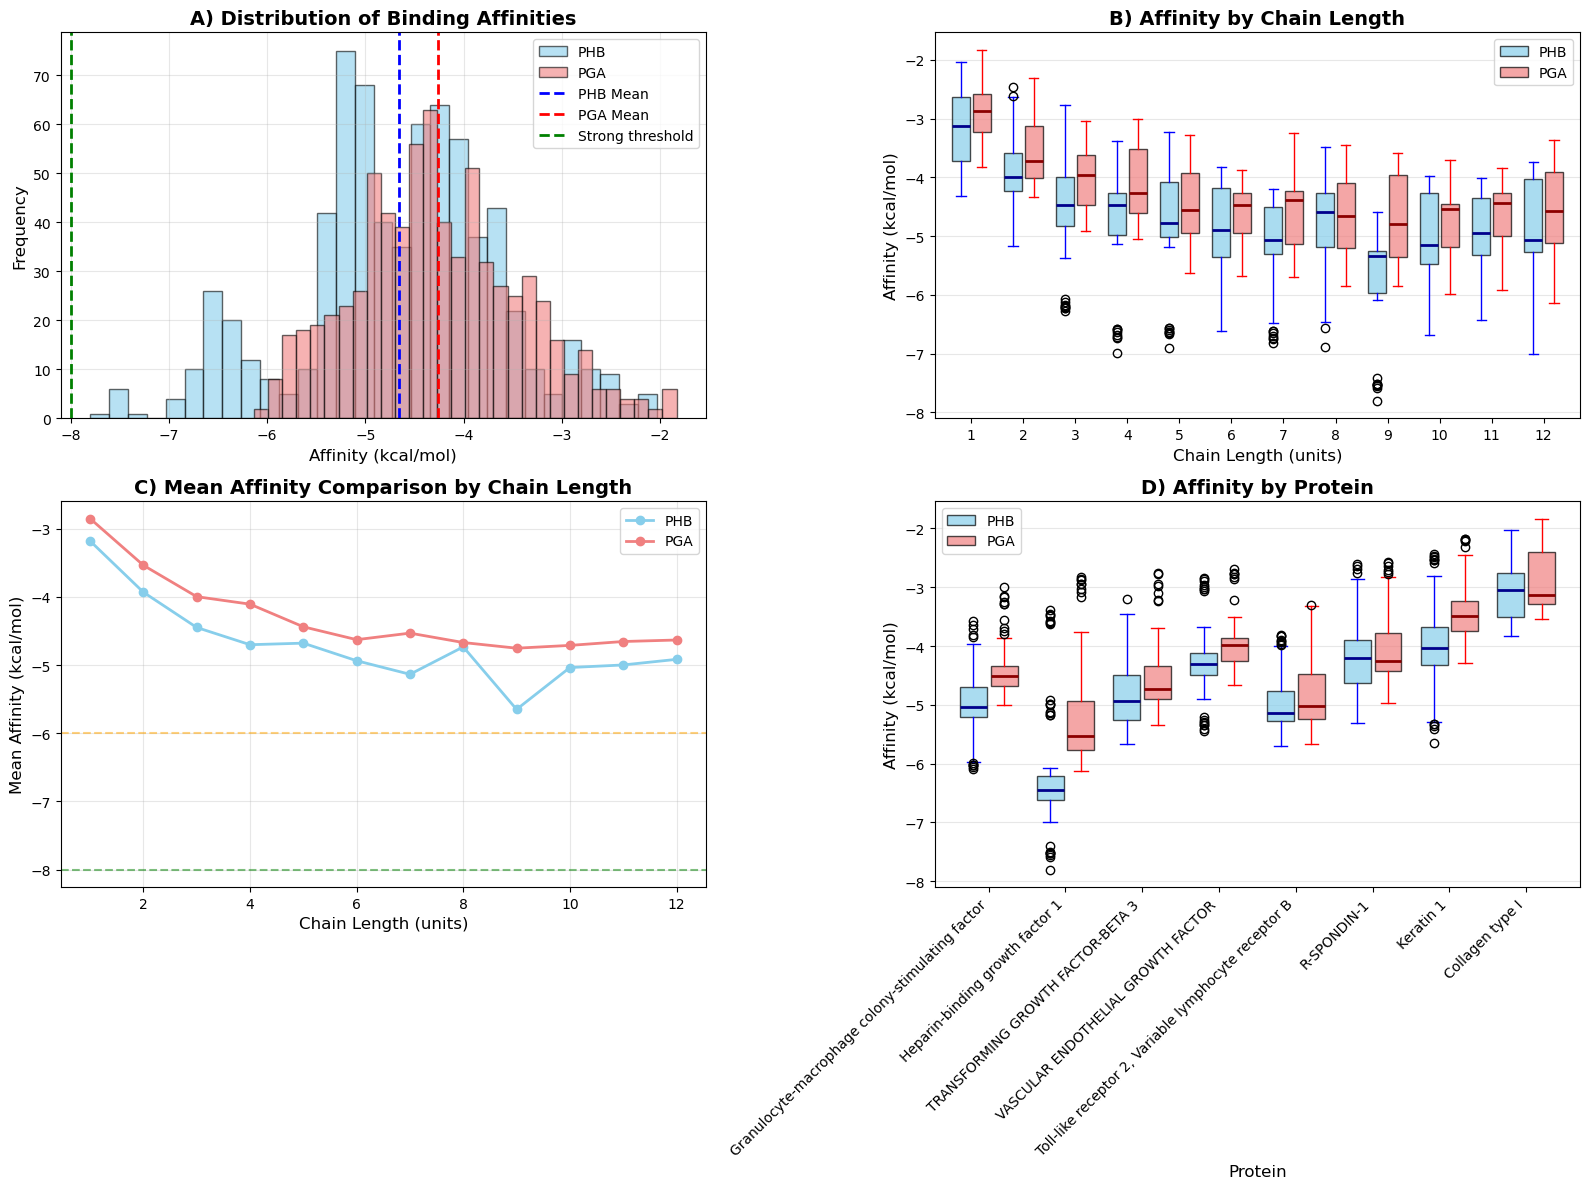

In [12]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot A: Distribution of binding affinities 
axes[0, 0].hist(summary_pd_phb['affinity_kcal_mol'], bins=30, edgecolor='black', 
                alpha=0.6, color='skyblue', label='PHB')
axes[0, 0].hist(summary_pd_pga['affinity_kcal_mol'], bins=30, edgecolor='black', 
                alpha=0.6, color='lightcoral', label='PGA')
axes[0, 0].axvline(summary_pd_phb['affinity_kcal_mol'].mean(), color='blue', 
                   linestyle='--', label='PHB Mean', linewidth=2)
axes[0, 0].axvline(summary_pd_pga['affinity_kcal_mol'].mean(), color='red', 
                   linestyle='--', label='PGA Mean', linewidth=2)
axes[0, 0].axvline(-8.0, color='green', linestyle='--', label='Strong threshold', linewidth=2)
axes[0, 0].set_xlabel('Affinity (kcal/mol)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('A) Distribution of Binding Affinities', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot B: Affinity by chain length 
chain_lengths = sorted(summary_pd_phb['chain_units'].unique())
positions_phb = np.arange(len(chain_lengths)) - 0.2
positions_pga = np.arange(len(chain_lengths)) + 0.2

# Create boxplot data
bp_data_phb = [summary_pd_phb[summary_pd_phb['chain_units'] == cl]['affinity_kcal_mol'].values 
               for cl in chain_lengths]
bp_data_pga = [summary_pd_pga[summary_pd_pga['chain_units'] == cl]['affinity_kcal_mol'].values 
               for cl in chain_lengths]

bp1 = axes[0, 1].boxplot(bp_data_phb, positions=positions_phb, widths=0.35,
                          patch_artist=True, 
                          boxprops=dict(facecolor='skyblue', alpha=0.7),
                          medianprops=dict(color='darkblue', linewidth=2),
                          whiskerprops=dict(color='blue'),
                          capprops=dict(color='blue'))
bp2 = axes[0, 1].boxplot(bp_data_pga, positions=positions_pga, widths=0.35,
                          patch_artist=True,
                          boxprops=dict(facecolor='lightcoral', alpha=0.7),
                          medianprops=dict(color='darkred', linewidth=2),
                          whiskerprops=dict(color='red'),
                          capprops=dict(color='red'))

axes[0, 1].set_xticks(np.arange(len(chain_lengths)))
axes[0, 1].set_xticklabels(chain_lengths)
axes[0, 1].set_xlabel('Chain Length (units)', fontsize=12)
axes[0, 1].set_ylabel('Affinity (kcal/mol)', fontsize=12)
axes[0, 1].set_title('B) Affinity by Chain Length', fontsize=14, fontweight='bold')
axes[0, 1].legend([bp1["boxes"][0], bp2["boxes"][0]], ['PHB', 'PGA'], loc='best')
axes[0, 1].grid(alpha=0.3, axis='y')

# Plot C: Mean affinity comparison by chain length
chain_comparison = pd.DataFrame({
    'PHB': ligand_stats_phb['mean'],
    'PGA': ligand_stats_pga['mean']
})
chain_comparison.plot(ax=axes[1, 0], marker='o', linewidth=2, color=['skyblue', 'lightcoral'])
axes[1, 0].set_xlabel('Chain Length (units)', fontsize=12)
axes[1, 0].set_ylabel('Mean Affinity (kcal/mol)', fontsize=12)
axes[1, 0].set_title('C) Mean Affinity Comparison by Chain Length', fontsize=14, fontweight='bold')
axes[1, 0].legend(['PHB', 'PGA'])
axes[1, 0].grid(alpha=0.3)
axes[1, 0].axhline(y=-8.0, color='green', linestyle='--', alpha=0.5, label='Strong threshold')
axes[1, 0].axhline(y=-6.0, color='orange', linestyle='--', alpha=0.5, label='Moderate threshold')

# Plot D: Affinity by protein 
# Function to clean protein names
def clean_protein_name(filename):
    """Remove PDB ID prefix and .pdbqt extension, replace _ with spaces"""
    # Remove .pdbqt extension
    name = filename.replace('.pdbqt', '')
    # Remove PDB ID (first 4 characters + underscore)
    if len(name) > 5 and name[4] == '_':
        name = name[5:]
    # Replace underscores with spaces
    name = name.replace('_', ' ')
    return name

# Get unique proteins and clean names
proteins = sorted(summary_pd_phb['protein_file'].unique())
protein_labels = [clean_protein_name(p) for p in proteins]

# Prepare data for overlapping boxplots by protein
positions_phb = np.arange(len(proteins)) - 0.2
positions_pga = np.arange(len(proteins)) + 0.2

bp_data_phb = [summary_pd_phb[summary_pd_phb['protein_file'] == p]['affinity_kcal_mol'].values 
               for p in proteins]
bp_data_pga = [summary_pd_pga[summary_pd_pga['protein_file'] == p]['affinity_kcal_mol'].values 
               for p in proteins]

bp1 = axes[1, 1].boxplot(bp_data_phb, positions=positions_phb, widths=0.35,
                          patch_artist=True, 
                          boxprops=dict(facecolor='skyblue', alpha=0.7),
                          medianprops=dict(color='darkblue', linewidth=2),
                          whiskerprops=dict(color='blue'),
                          capprops=dict(color='blue'))
bp2 = axes[1, 1].boxplot(bp_data_pga, positions=positions_pga, widths=0.35,
                          patch_artist=True,
                          boxprops=dict(facecolor='lightcoral', alpha=0.7),
                          medianprops=dict(color='darkred', linewidth=2),
                          whiskerprops=dict(color='red'),
                          capprops=dict(color='red'))

axes[1, 1].set_xticks(np.arange(len(proteins)))
axes[1, 1].set_xticklabels(protein_labels, rotation=45, ha='right', fontsize=10)
axes[1, 1].set_xlabel('Protein', fontsize=12)
axes[1, 1].set_ylabel('Affinity (kcal/mol)', fontsize=12)
axes[1, 1].set_title('D) Affinity by Protein', fontsize=14, fontweight='bold')
axes[1, 1].legend([bp1["boxes"][0], bp2["boxes"][0]], ['PHB', 'PGA'], loc='best')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output/phb_pga_comparison_analysis.svg', dpi=300, bbox_inches='tight')
plt.show()

## **9. INTERPRETATION SUMMARY**

Integrated assessment of three key metrics: (1) mean affinity, (2) consistency (CV), (3) pose quality (RMSD spread).

In [13]:
print("INTERPRETATION SUMMARY - PHB")
print("="*70)

mean_affinity_phb = summary_pd_phb['affinity_kcal_mol'].mean()
print(f"\nMean affinity: {mean_affinity_phb:.2f} kcal/mol")
if mean_affinity_phb < -8.0:
    print("\t- Strong binding detected")
elif mean_affinity_phb < -6.0:
    print("\t- Moderate binding detected")
elif mean_affinity_phb < -4.0:
    print("\t- Weak binding detected")
else:
    print("\t- Very weak/no binding detected")

avg_cv_phb = protein_cv_phb.mean()
print(f"\nAverage Consistency (CV): {avg_cv_phb:.1f}%")
if avg_cv_phb < 30:
    print("\t- Consistent binding across poses")
else:
    print("\t- Inconsistent binding (high variation)")

avg_rmsd_spread_phb = summary_pd_phb['rmsd_spread'].mean()
print(f"\nAverage RMSD Spread: {avg_rmsd_spread_phb:.2f} Å")
if avg_rmsd_spread_phb < 5:
    print("\t- Poses are well-defined (low spread)")
else:
    print("\t- Poses are poorly defined (high spread)")

print(f"\nOptimal chain length: {optimal_chain_phb} units ({optimal_affinity_phb:.3f} kcal/mol)")

print("\nINTERPRETATION SUMMARY - PGA")
print("="*70)

mean_affinity_pga = summary_pd_pga['affinity_kcal_mol'].mean()
print(f"\nMean affinity: {mean_affinity_pga:.2f} kcal/mol")
if mean_affinity_pga < -8.0:
    print("\t- Strong binding detected")
elif mean_affinity_pga < -6.0:
    print("\t- Moderate binding detected")
elif mean_affinity_pga < -4.0:
    print("\t- Weak binding detected")
else:
    print("\t- Very weak/no binding detected")

avg_cv_pga = protein_cv_pga.mean()
print(f"\nAverage Consistency (CV): {avg_cv_pga:.1f}%")
if avg_cv_pga < 30:
    print("\t- Consistent binding across poses")
else:
    print("\t- Inconsistent binding (high variation)")

avg_rmsd_spread_pga = summary_pd_pga['rmsd_spread'].mean()
print(f"\nAverage RMSD Spread: {avg_rmsd_spread_pga:.2f} Å")
if avg_rmsd_spread_pga < 5:
    print("\t- Poses are well-defined (low spread)")
else:
    print("\t- Poses are poorly defined (high spread)")

print(f"\nOptimal chain length: {optimal_chain_pga} units ({optimal_affinity_pga:.3f} kcal/mol)")

print("\n" + "="*70)
print("OVERALL COMPARISON")
print("="*70)

if mean_affinity_phb < mean_affinity_pga:
    better_polymer = "PHB"
    diff = mean_affinity_pga - mean_affinity_phb
else:
    better_polymer = "PGA"
    diff = mean_affinity_phb - mean_affinity_pga

print(f"\n{better_polymer} shows better binding affinity by {diff:.3f} kcal/mol")

if p_value < 0.05:
    print("This difference is statistically significant (p < 0.05)")
else:
    print("This difference is NOT statistically significant (p >= 0.05)")

INTERPRETATION SUMMARY - PHB

Mean affinity: -4.66 kcal/mol
	- Weak binding detected

Average Consistency (CV): 13.6%
	- Consistent binding across poses

Average RMSD Spread: 3.93 Å
	- Poses are well-defined (low spread)

Optimal chain length: 9 units (-5.650 kcal/mol)

INTERPRETATION SUMMARY - PGA

Mean affinity: -4.26 kcal/mol
	- Weak binding detected

Average Consistency (CV): 13.7%
	- Consistent binding across poses

Average RMSD Spread: 3.07 Å
	- Poses are well-defined (low spread)

Optimal chain length: 9 units (-4.752 kcal/mol)

OVERALL COMPARISON

PHB shows better binding affinity by 0.397 kcal/mol
This difference is statistically significant (p < 0.05)


## END